In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.config import processed_data_dir

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Analysis

In [2]:
data_df = pd.read_json(processed_data_dir / "products_reviews.json.gz")

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")
data_df["brand"] = data_df["brand"].astype("category")
data_df["category"] = data_df["category"].astype("category")
data_df["description"] = data_df["description"].astype("string")
data_df["title"] = data_df["title"].astype("string")

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53193 entries, 0 to 53192
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   asin         53193 non-null  category      
 1   overall      53193 non-null  category      
 2   summary      53193 non-null  string        
 3   text         53193 non-null  string        
 4   timestamp    53193 non-null  datetime64[ns]
 5   vote         53193 non-null  int64         
 6   brand        53193 non-null  category      
 7   category     53193 non-null  category      
 8   description  53193 non-null  string        
 9   title        53193 non-null  string        
dtypes: category(4), datetime64[ns](1), int64(1), string(4)
memory usage: 3.3 MB


# ASIN

Mean number of reviews: 10.50414691943128


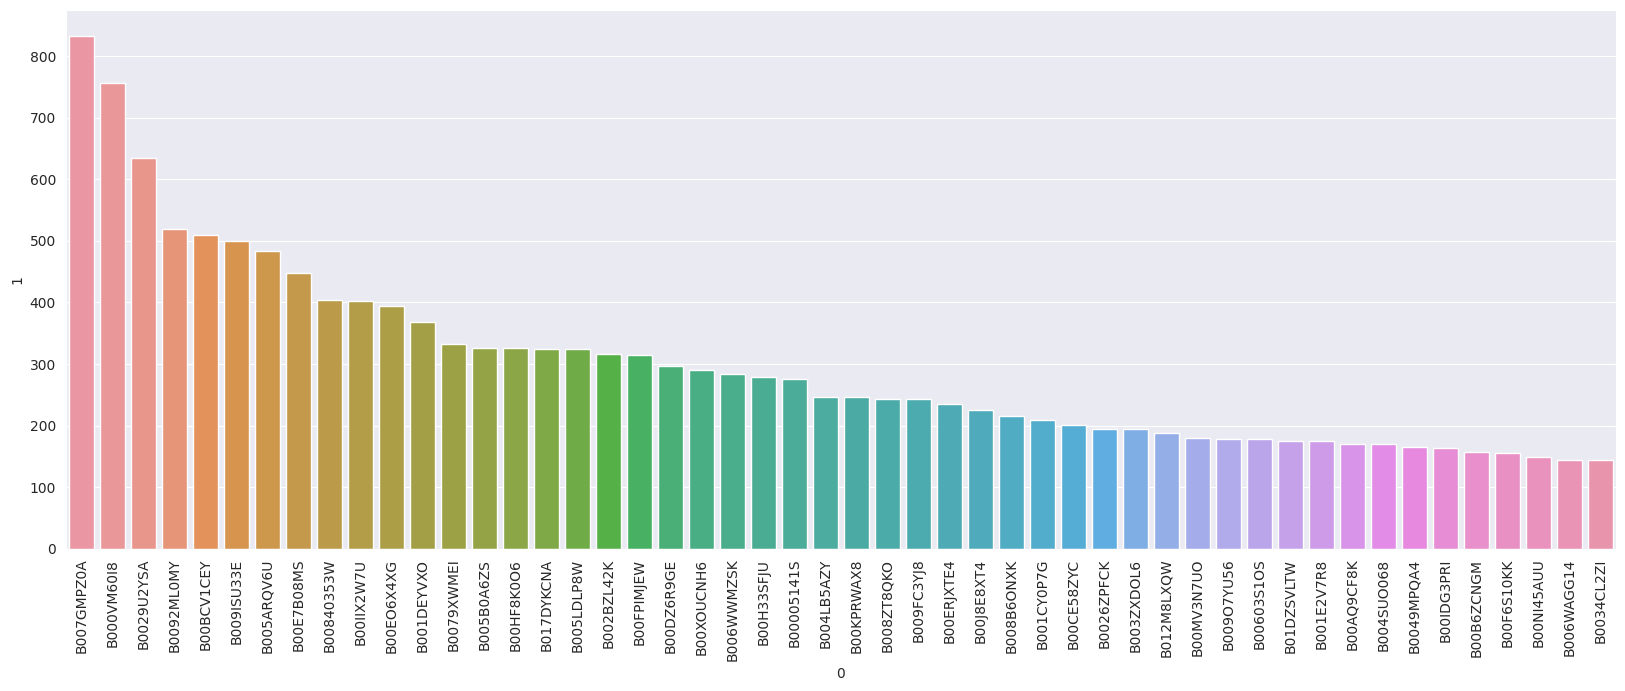

In [3]:
# number of reviews per product (ASIN)
data = pd.DataFrame(Counter(data_df["asin"].tolist()).most_common(50))
_, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=90)
sns.barplot(x=data[0], y=data[1], ax=ax)

# average number of reviews
z = pd.DataFrame(data_df["asin"].value_counts())
print("Mean number of reviews:", z["asin"].mean())

# Title

In [4]:
# most reviewed titles
c = Counter(data_df["title"].astype("string")).most_common(10)
pd.DataFrame(c, columns=["title", "frequency"])

,title,frequency
0,TP-Link TL-WDN4800 N900 Dual Band PCI-E Wirele...,833
1,Diamond VC500 USB 2.0 One Touch VHS to DVD Vid...,756
2,"Elgato Video Capture - Digitise Video for Mac,...",634
3,Corsair CX Series 500 Watt 80 Plus Bronze Cert...,519
4,TP-Link 10/100/1000Mbps Gigabit PCI Network Ad...,509
5,Sound Blaster Z PCIe Gaming Sound Card with Hi...,500
6,Anker Uspeed USB 3.0 PCI-E Express Card with 4...,484
7,LG WH16NS40 Super Multi Blue Internal SATA 16x...,448
8,Elgato Game Capture HD - Xbox and PlayStation ...,404
9,Lite-On Super AllWrite IHAS124-04-KIT 24X DVD+...,403


# Brand & Category

### Most Reviewed Brand

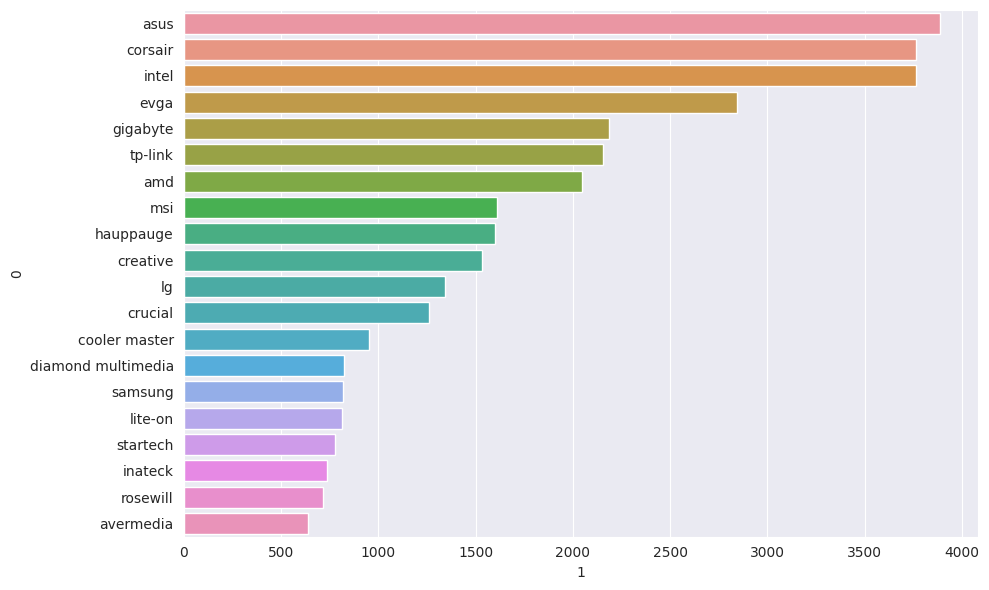

In [5]:
data = pd.DataFrame(Counter(data_df["brand"].tolist()).most_common(20))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=data[0], x=data[1], ax=ax)
fig.tight_layout()

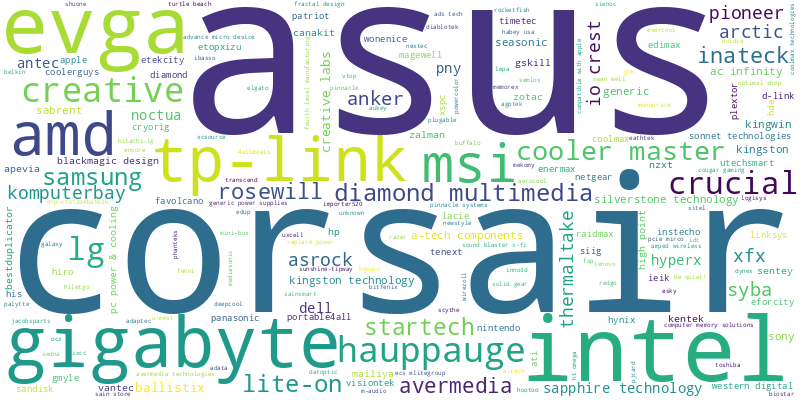

In [6]:
c = Counter(list(data_df["brand"]))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

### Most Reviewed Categories

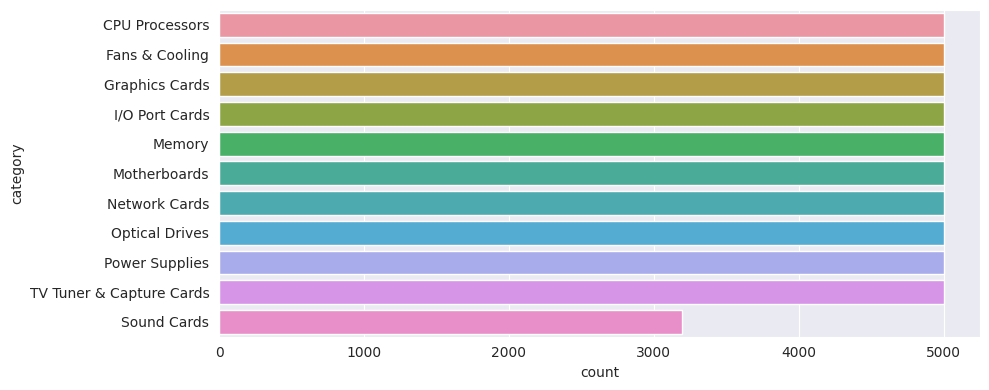

In [7]:
fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(y=data_df["category"].astype("string"))
fig.tight_layout()

### Top 5 brand per Category

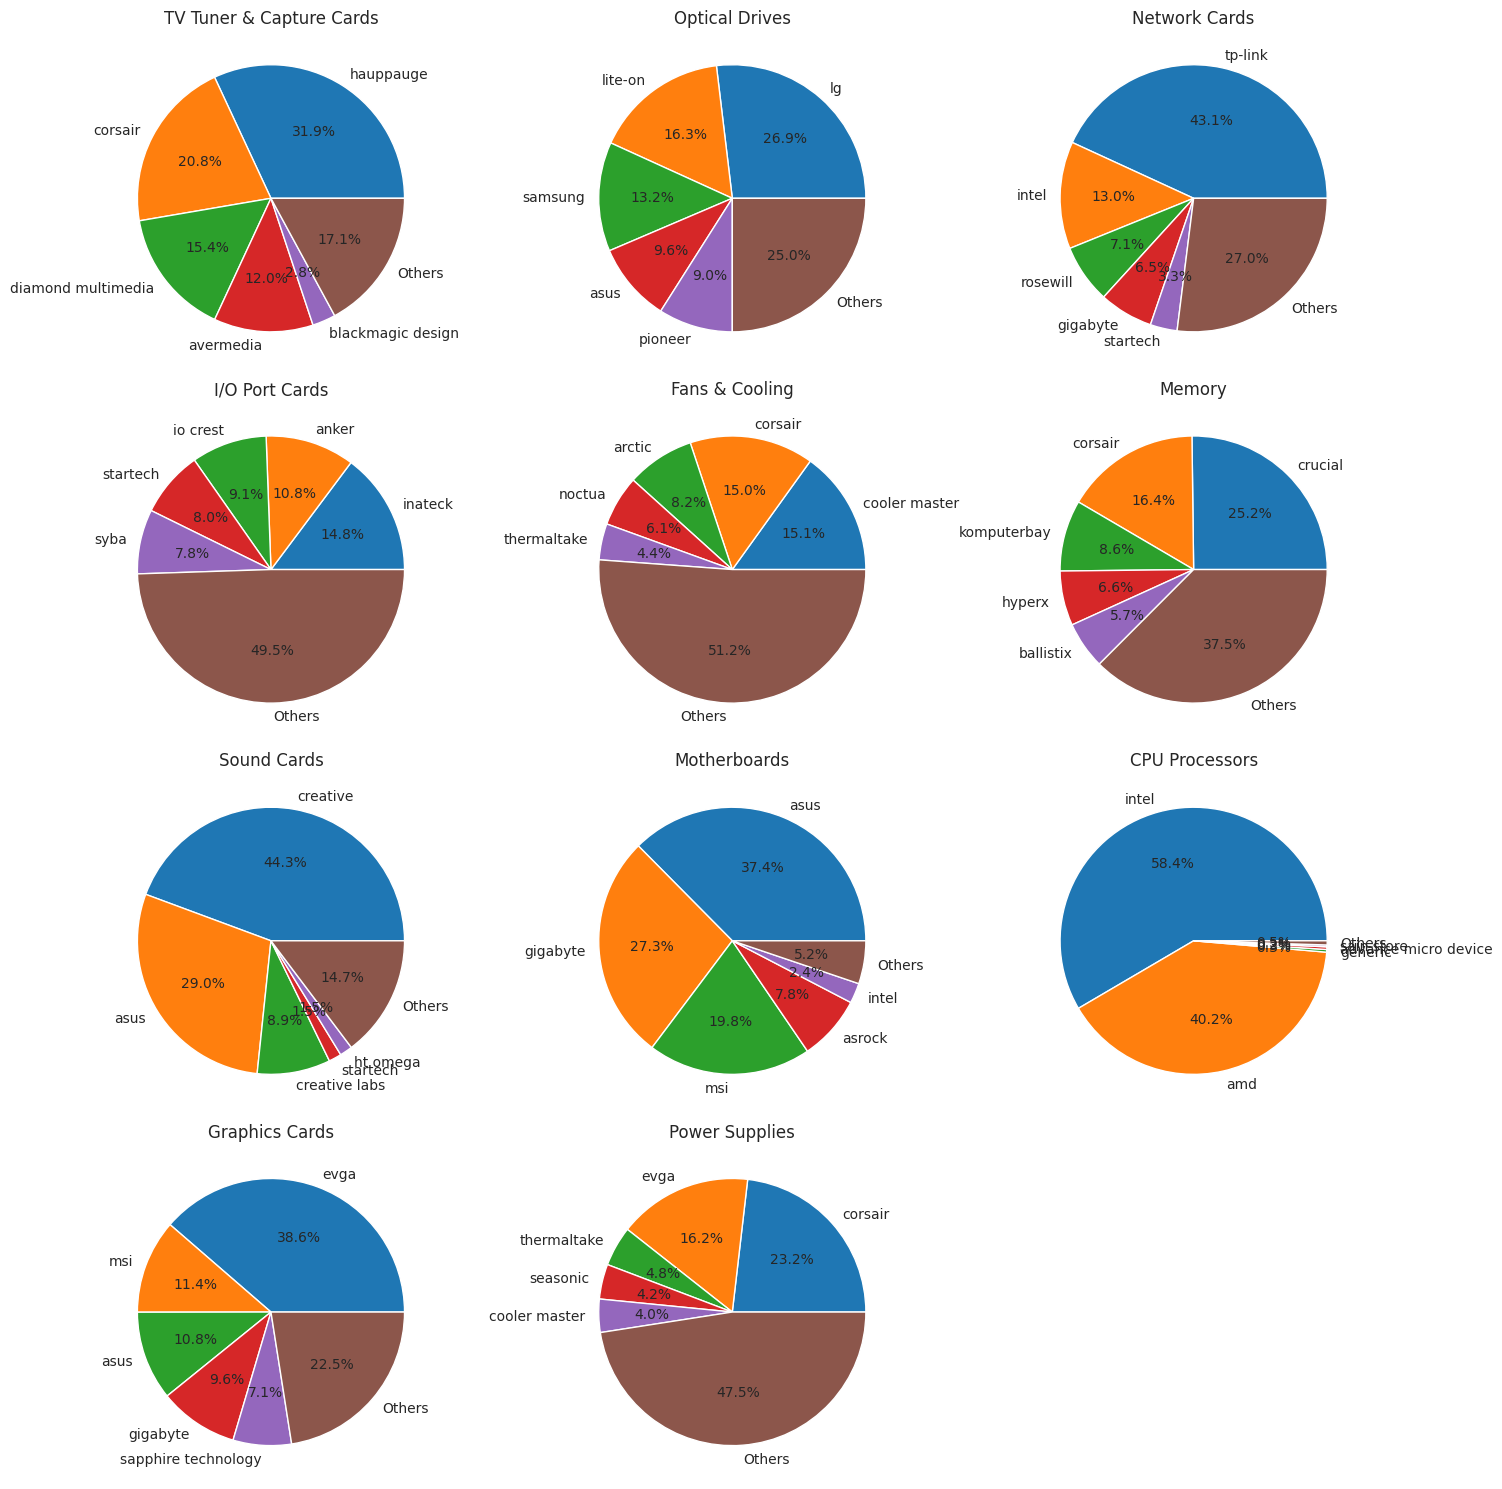

In [29]:
categories = set(data_df["category"])
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()

for i, cat in enumerate(categories):
    z = data_df.loc[data_df["category"] == cat]["brand"]
    data = pd.DataFrame(
        Counter(z.tolist()).most_common(), columns=["brand", "count"]
    ).reset_index(drop=True)

    if len(data) > 5:
        others = pd.DataFrame(
            data={"brand": ["Others"], "count": [data["count"][5:].sum()]}
        )

        data = pd.concat([data[:5], others])

    data.set_index("brand", inplace=True)

    data.plot(
        y="count",
        x=data.index.values,
        kind="pie",
        legend=False,
        autopct="%1.1f%%",
        ax=axes[i],
    )

    axes[i].set_title(cat)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

fig.delaxes(axes[-1])
fig.tight_layout()

# Review Time Series

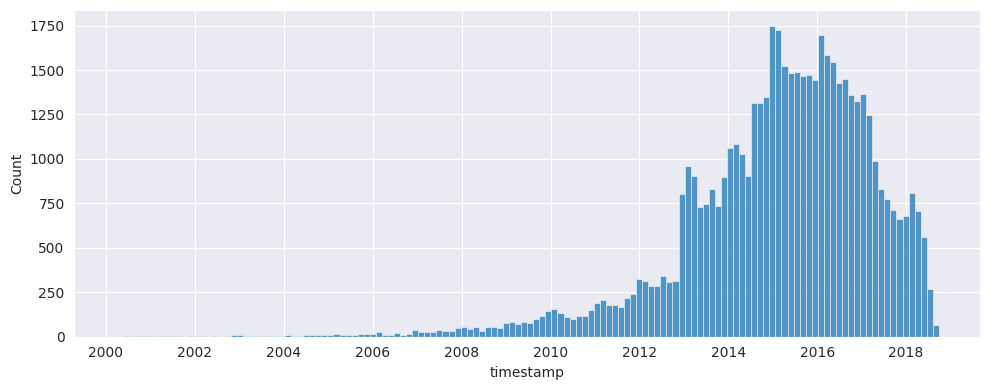

In [9]:
# number of reviews over time of the brand X

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(data_df["timestamp"], ax=ax)
fig.tight_layout()

# Review Text and Summary

### Summary

In [10]:
data_df["summary"].head(20)

0                                            Five Stars
1                               Not Necessarily 8 Cores
2                                        Really like it
3                               Good basic PC platform.
4                                 You only get one shot
5     one of them l built for him and it's a server ...
6                               Intel has scored again!
7                                            Five Stars
8                                            Five Stars
9                                           Three Stars
10                                           Five Stars
11            APU is lacking with weak processing power
12                                           Five Stars
13                               Very nice i5-4690K CPU
14                                      Fast Processor!
15                                Have never maxed out!
16                                          Three Stars
17                                           Fiv

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


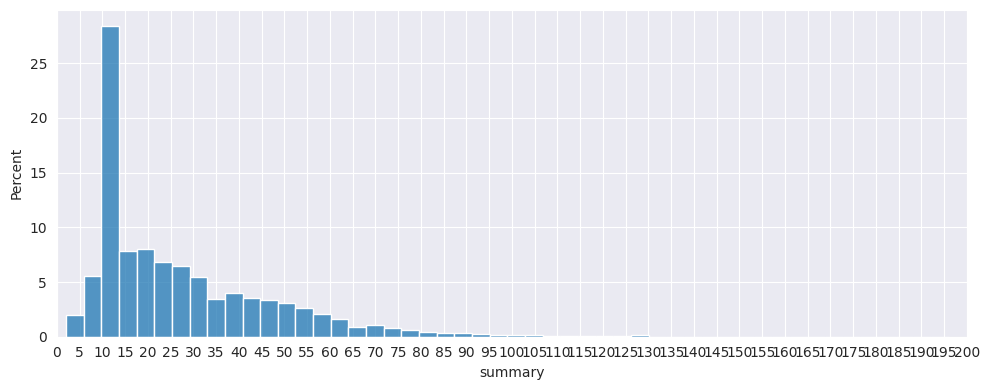

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim([0, 200])
ax.set_xticks(range(0, 205, 5))
sns.histplot(x=data_df["summary"].str.len(), stat="percent", bins=50, ax=ax)
fig.tight_layout()

In [12]:
mean_length = np.round(np.mean(data_df["summary"].str.len()))
print("mean summary length:", mean_length, "characters")

data_df[data_df["summary"].str.len() == mean_length]["summary"].head(30)

mean summary length: 27.0 characters


148     Excellent CPU for the price
186     Complete overkill at stock.
324     Good midrange OC processor.
379     Good cpu for replacement HP
424     Fast and Reliable for Cheap
452     Fast and Awesome Potential!
458     Best performance per dollar
526     can't beat it for the money
545     Great CPU, almost flawless.
584     i5 is great, no need for i7
673     Dosn't really compare to i7
725     Good Deal on a Capable Chip
761     this is the best to go with
980     The best CPU for the money.
1024    so i recommended an upgrade
1125    Fast and cool.  As expected
1217    Great CPU/GPU for the price
1218    Great value for your wallet
1247    I absolutely LOVE this CPU!
1290    Plug and play, no problems.
1320    Great speed and reliability
1402    Best processor for LGA 775!
1420    Budget winner!  Hands down.
1566    Can't Beat it For The Price
1666    Great processor, good speed
1697    Huge overclocking potential
1825    Easy OC to 4.7 GHZ at 1.29V
1828    for the price, a gre

In [13]:
# top 3 most common summary length
len10 = set(data_df[data_df["summary"].str.len() == 10]["summary"].head(20))
len11 = set(data_df[data_df["summary"].str.len() == 11]["summary"].head(20))
len9 = set(data_df[data_df["summary"].str.len() == 9]["summary"].head(20))

print(len10, "\n\n", len11, "\n\n", len9)

{'Four Stars', 'great cpu!', 'Five Stars'} 

 {'Easy setup!', 'Awsome Chip', 'great price', 'Amd Fan boy', 'Awesomeness', 'DIY Upgrade', 'Three Stars', 'Great Value', 'Did the Job', 'Works great', 'OUTSTANDING', 'Great deal!', 'Performance', 'Amd fx 4100'} 

 {'Thumbs up', 'Worth it.', 'It works.', 'Two Stars', 'Efficient', 'I LOVE IT', 'Good CPU.', 'Excellent', 'Great CPU', 'Very Fast', 'Top Value', 'very good', 'great cpu', 'Nice Chip', '$99 Works', 'Beautiful', 'The Beast', 'i like it', 'Very Good'}


### Text

In [14]:
data_df["text"].head(20)

0     Used this for my first build and I love it.  I...
1     I bought this processor for the purpose of per...
2     This is not a perfect computer but it is getti...
3     This is a great little four core that only sip...
4     Be extra careful not to bend the pins if you d...
5     it's not the piece of trash l thought it would...
6     This CPU is the bomb!  I have tried AMDs CPUs ...
7                Nice speed increase at a modest price.
8                                                 Good.
9     getting crashes and monitor flickering from ti...
10                                        As described.
11    Sorry, but the APU is lacking and the processi...
12    Used it to build my rig and have been working ...
13    This is a solid CPU. After reading reviews fro...
14    The i7-4790 is FAAAAST! I installed it on an A...
15    This CPU is a beast.  THere's no other word fo...
16                                                 good
17    my son loves this worked well for his buil

/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/ubuntu/Desktop/amazon-reviews/venv/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


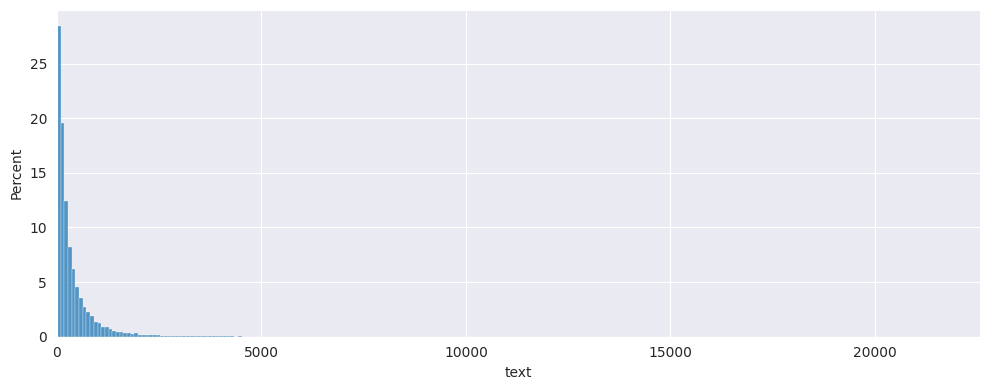

In [15]:
text_lengths = data_df["text"].str.len()

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(text_lengths, stat="percent", bins=250, ax=ax)
ax.set_xlim([0, np.max(text_lengths)])
fig.tight_layout()

In [16]:
mean_length = np.round(np.mean(text_lengths))
print("mean text length:", mean_length, "characters")

data_df[text_lengths == mean_length]["text"].head(10)

mean text length: 388.0 characters


1655     If you are like me and want to build a simple ...
3689     Paired with 8GB of RAM and a Samsung 850 EVO M...
4451     It was between this and the i7 and i7k for awh...
6303     Very impressed with this fan. I use it as an e...
7754     Works great for OC. Did quite a bit of testing...
8766     These fans are great! Pack a lot of power, lar...
9999     The Zalman CNPS7000V-AL(PWM) is loud and not v...
16680    Actually, the USB card works great in my Mac P...
17584    Works flawless in older PCI slot based MAC des...
19841    As serial devices are becoming fewer and farth...
Name: text, dtype: string

In [17]:
# top 3 most common text length
len9 = set(data_df[text_lengths == 9]["text"].head(10))
len12 = set(data_df[text_lengths == 12]["text"].head(10))
len11 = set(data_df[text_lengths == 11]["text"].head(10))

print(len9, "\n\n", len12, "\n\n", len11)

{'thank you', 'great buy', 'It rocks.', 'excellent', 'but works', 'very good', 'It works.'} 

 {'new computer', 'GOOD >> GOOD', 'GOOD QUALITY', 'So worth it!', 'Good Product', 'worked great', 'Good product', 'working hard'} 

 {'Works great', 'very good !', 'Works well.', 'buy it now!', 'As expected', 'little weak', 'Really nice', 'Works fine.'}


### SUMMARY + TEXT

In [18]:
summary_text = []
for i, row in data_df.iterrows():
    end_line = ".\n"
    if row["summary"].endswith("."):
        end_line = "\n"
    summary_text.append(row["summary"] + end_line + row["text"])
data_df["summary+text"] = summary_text

for i in range(3):
    print(data_df["summary+text"][i], "\n")

Five Stars.
Used this for my first build and I love it.  I have yet to overclock, but it works excellent. 

Not Necessarily 8 Cores.
I bought this processor for the purpose of performing calculations with a program called MATLAB.  Number crunching was relatively slow on my old computer, so I decided to upgrade to the following $60, dual-core Pentium processor:

 Intel Pentium Processor G3220 3.0 GHz LGA 1150 BX80646G3220

The speed of my calculations improved, but the rate still wasn't fast enough.  So I figured, I'd step things up with the AMD FX-8320E 8-core processor.  It has a faster clock speed, and with more cores, I figured I'd see a dramatic increase in speed (hopefully by a factor of 4).  Unfortunately, this wasn't the case.  In fact, the dual-core Intel processor initially out-performed the FX-8320E.  With the Intel processor, my calculations took about 27 minutes to complete.  With the FX-8320E, they take around 48 minutes.  This was out-of-the-box performance, meaning that 

# Overall

<AxesSubplot: ylabel='overall'>

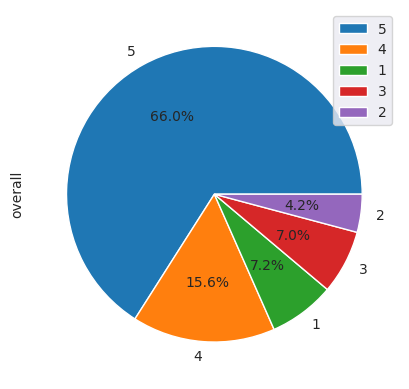

In [19]:
# number by starts
data_df["overall"].value_counts(normalize=True).plot(
    kind="pie", legend=True, autopct="%1.1f%%"
)

<AxesSubplot: ylabel='overall'>

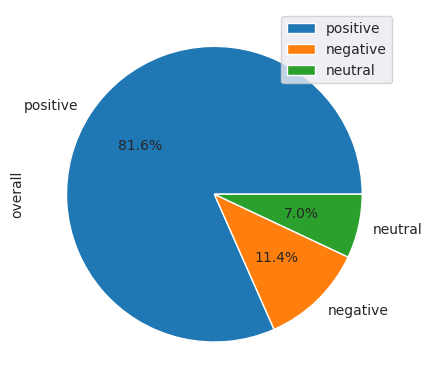

In [20]:
# ground truth polarity
polarity_overall = data_df["overall"].parallel_apply(
    lambda o: "positive" if o > 3 else ("neutral" if o == 3 else "negative")
)
polarity_overall.value_counts(normalize=True).plot(
    kind="pie", legend=True, autopct="%1.1f%%"
)

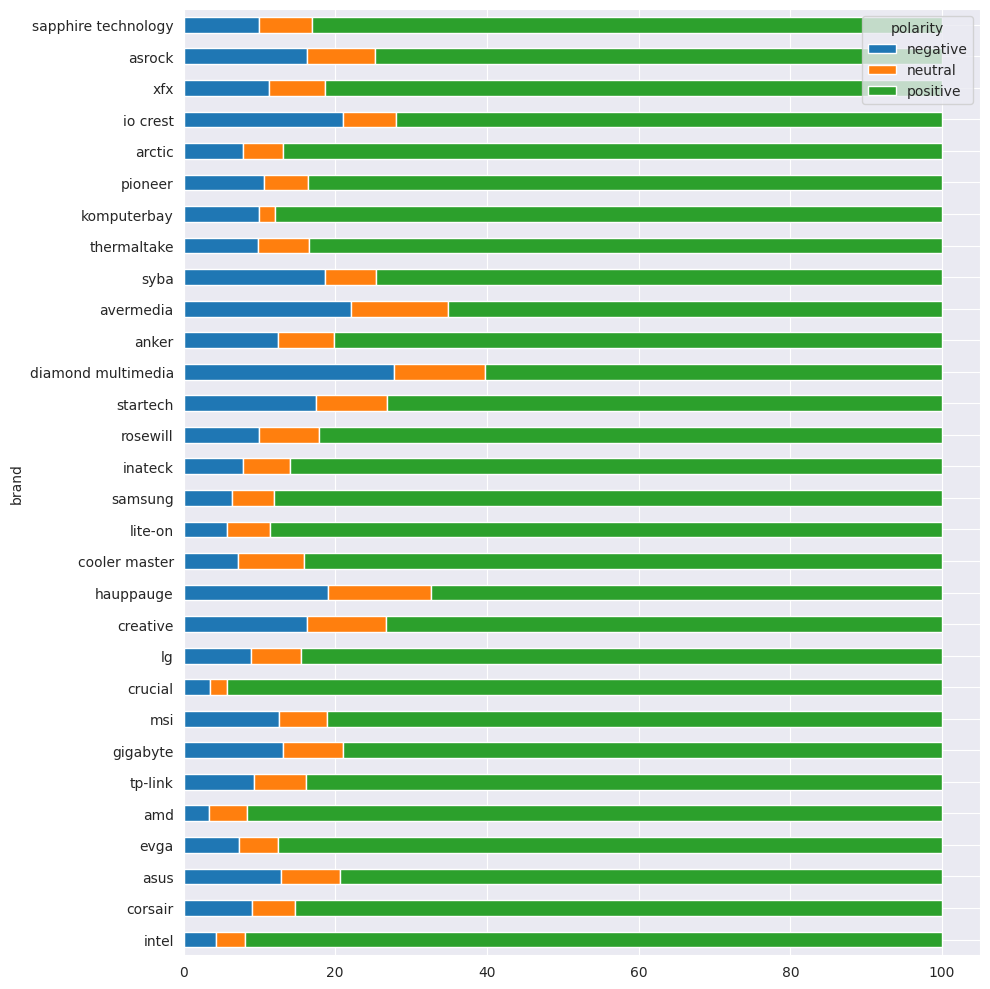

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

data = pd.DataFrame(Counter(data_df["brand"]).most_common(30))

data = data_df.loc[data_df["brand"].isin(set(data[0]))].copy()
data["polarity_overall"] = polarity_overall
x = (
    data[["brand", "polarity_overall"]]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index(name="count")
)
x = x.pivot(columns="polarity", index="brand", values="count")

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

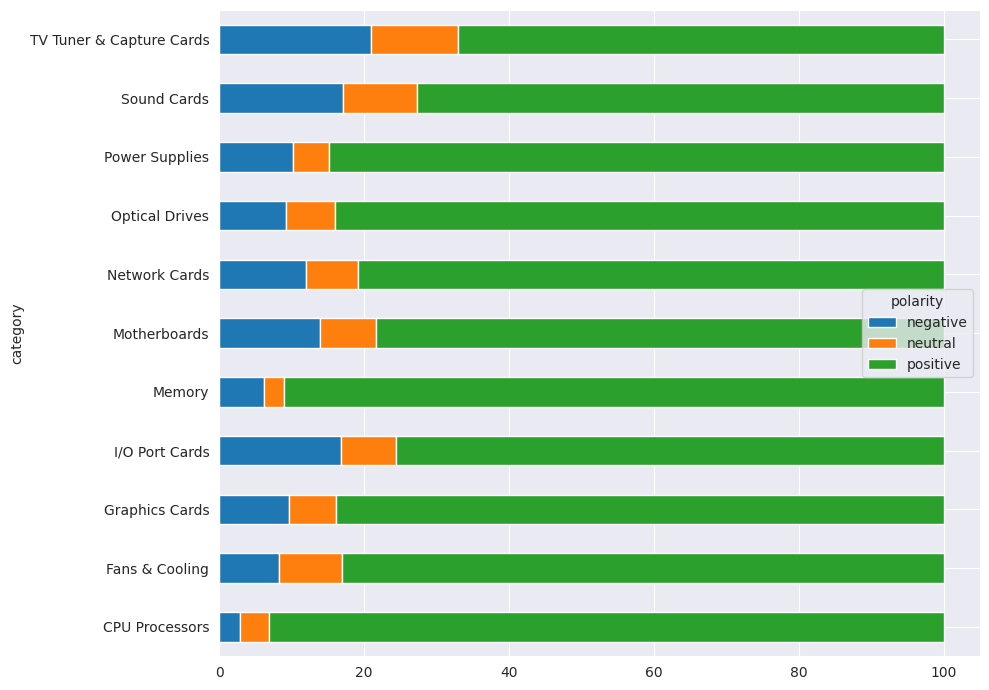

In [22]:
fig, ax = plt.subplots(figsize=(10, 7))

data_df["polarity_overall"] = polarity_overall
x = (
    data_df.groupby("category")["polarity_overall"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="polarity_overall")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="barh", stacked=True, ax=ax)
fig.tight_layout()

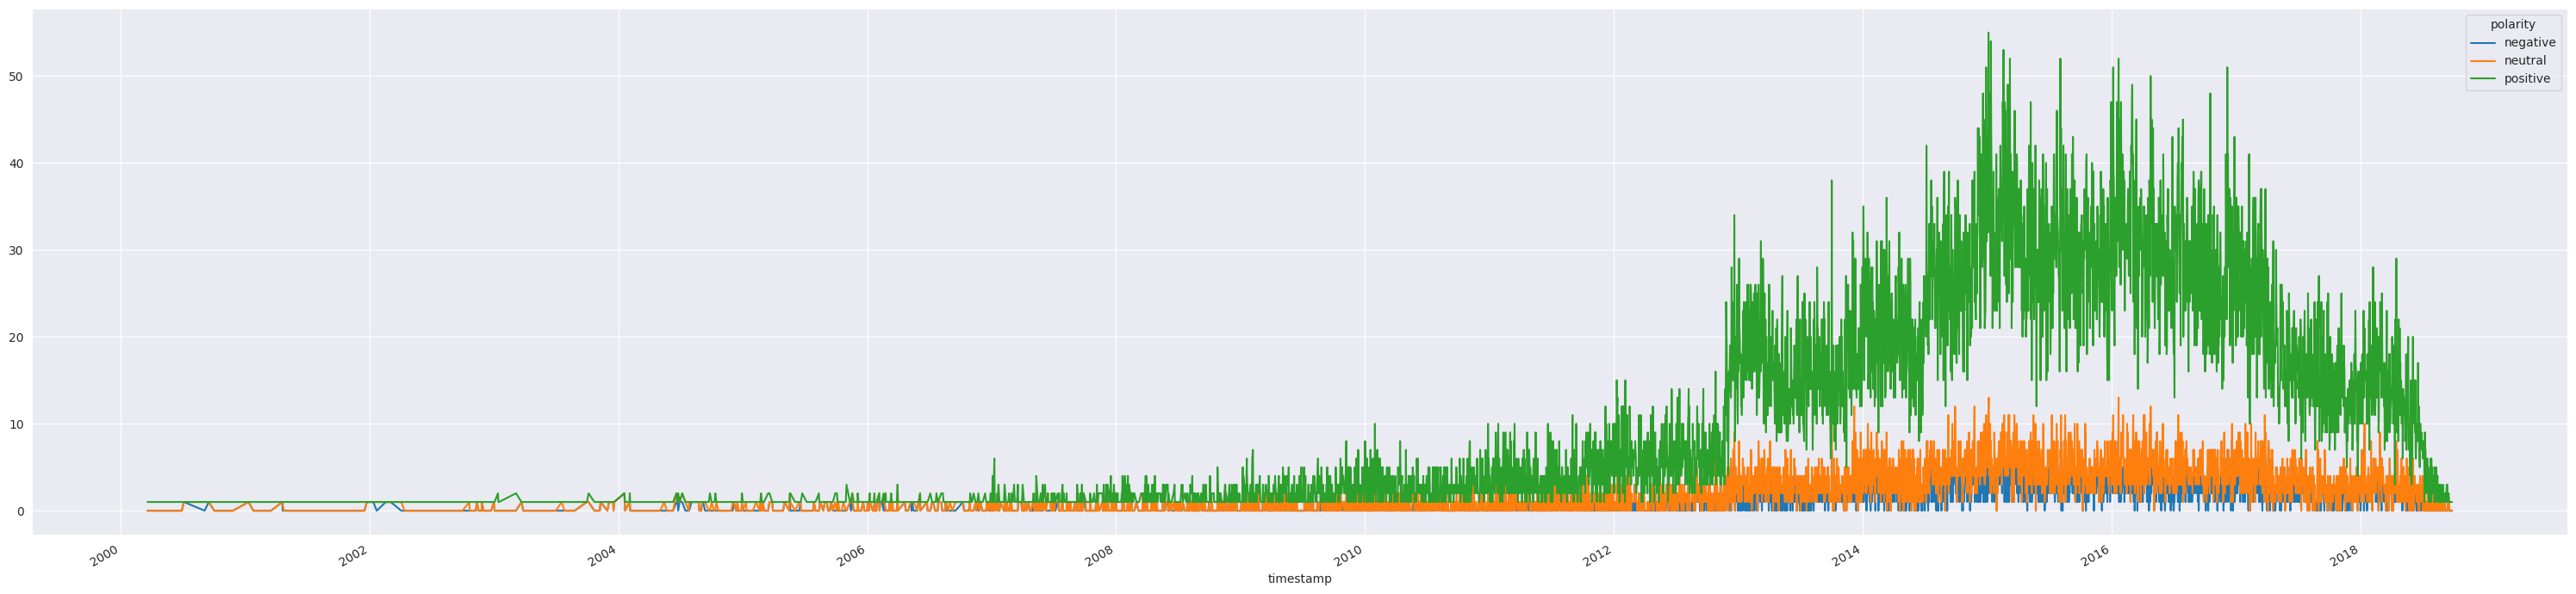

In [23]:
# Overall over time

fig, ax = plt.subplots(figsize=(30, 7))
plt.xticks(rotation=90)

x = (
    data_df.groupby("timestamp")["polarity_overall"]
    .value_counts()
    .rename_axis(["timestamp", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="timestamp", values="polarity_overall")
)
x.reset_index(inplace=True)

x.plot(x="timestamp", kind="line", stacked=True, ax=ax)
fig.tight_layout()

# Vote

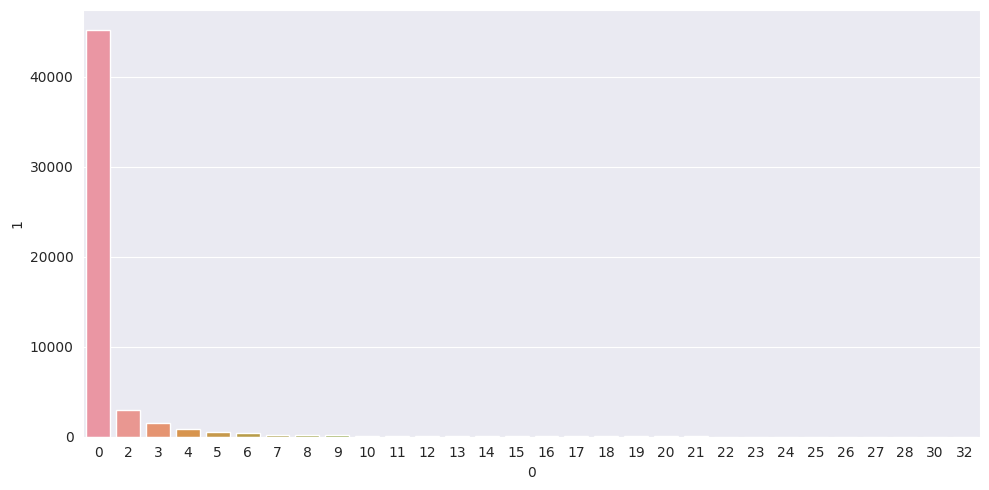

In [24]:
# count of helpful vote number

data = pd.DataFrame(Counter(data_df["vote"].tolist()).most_common(30))
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=data[0], y=data[1], ax=ax)
fig.tight_layout()

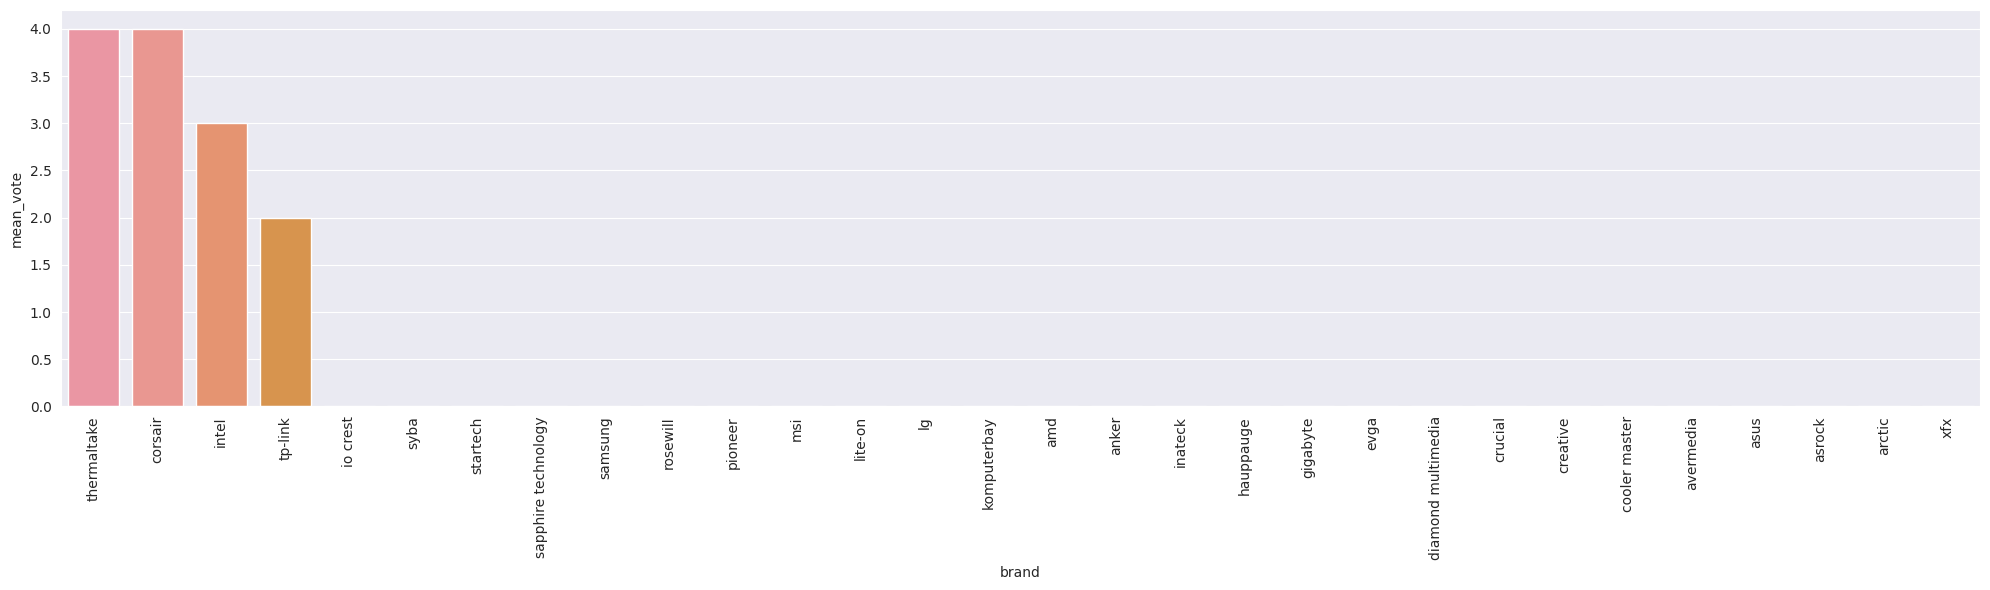

In [25]:
# mean number of util vote for brand

df = data_df.copy()
c = pd.DataFrame(Counter(list(df["brand"])).most_common(30))
df["brand"] = c[0]
df = df.groupby(["brand"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(
    x=df["brand"],
    y=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).brand,
)
plt.xticks(rotation=90)
fig.tight_layout()

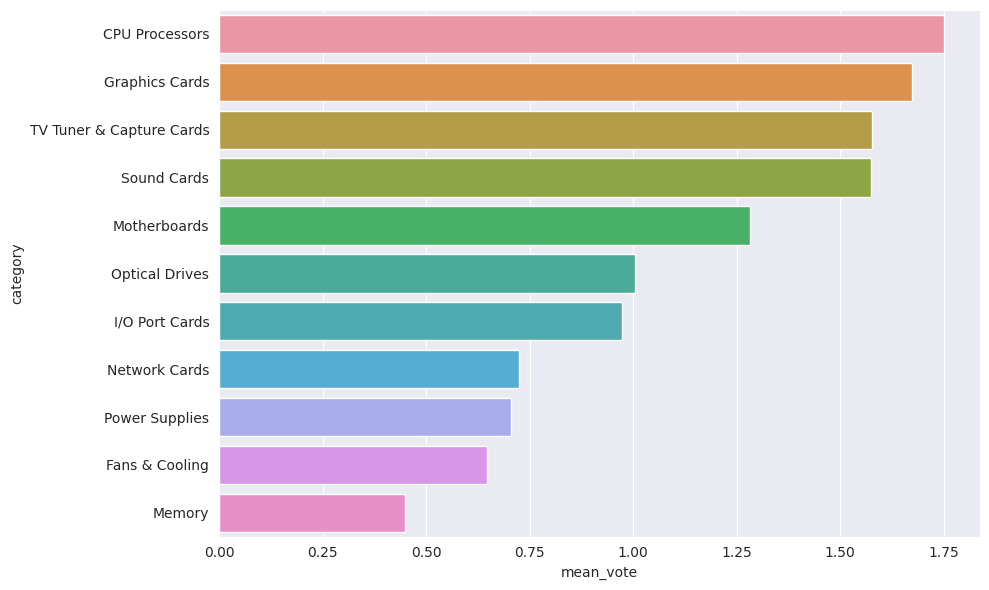

In [26]:
# mean number of util vote for category

df = data_df.copy()
df = df.groupby(["category"]).agg({"vote": [np.mean]})
df.columns = ["mean_vote"]
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    y=df["category"],
    x=df["mean_vote"],
    ax=ax,
    order=df.sort_values(by="mean_vote", ascending=False).category,
)
fig.tight_layout()